# Wheelchair Control

![](images/wheelchair.jpg)

### Python Dependencies

In [1]:
from numpy import *
from numpy.linalg import *

from scipy.linalg import *
from scipy.integrate import *
from scipy.signal import *

from matplotlib.pyplot import *

Step 1 - Wheelchair Planar Model
================================

### Introduction

We consider a simple model of a wheelchair evolving in the plane. It is mainly made of

  - A frame ; from above, its most visible component is the seat. We assume that it is a square,

  - Two fixed wheels (their orientation with respect to the frame does not change). 
    They are parallel and located at opposite ends of the seat. 
    
We assume that the seat backrest is on top of the wheels common axis.


Let $(0, e_x, e_y)$ be a direct orthonormal frame of the plane. We denote 

  - $(x, y)$ the coordinates of the wheel axis center in the orthonormal and 
  - $\theta$ the angle of the wheels direction with respect to vector $e_x$ ; with $\theta = 0$ when the front of the wheelchait faces the right ($e_x$) and $\theta = \pi/2$ when it faces upwards ($e_y$).

  - $\phi_l$ and $\phi_r$ the rotation angles of the left and right wheel respectively ; by convention, when these angles increase, the wheelchair moves forward.

### Parameter Definition

From now on, we assume that the seat side length is $L = 50 \mbox{ cm}$ and the wheel radius is $R_w = 30 \mbox{ cm}$.

🧩 Define the corresponding Python variables `L` and `Rw` (express every length in meters, and more generally in the sequel, always use the [international standard of units](https://en.wikipedia.org/wiki/SI_derived_unit)) for numerical values. 

In [2]:
L = 0.5
Rw = 0.3

### Graphical Representation

🧩 Implement a function `draw_wheelchair` with arguments `x`, `y` and `theta` that draws a simple geometric model of the wheelchair (with seat and fixed wheels) in the plane (top view) for arbitrary values of $(x, y)$ and $\theta$. 

🗝️ **Hint.** Use the function `plot` of `matplotlib.pyplot`.

In [33]:
import matplotlib.pyplot as plt
import numpy as np

def draw_wheelchair(x, y, theta):
    L = 0.5  # meters
    Rw = 0.3  # meters


    # Coordonnées des quatre coins du siège
    y=-y
    corners = np.array([
        [x - L/2, y - Rw/2],
        [x - L/2, y + Rw/2],
        [x + L/2, y + Rw/2],
        [x + L/2, y - Rw/2]
    ])

   # Centre de gravité
    cog = np.mean(corners, axis=0)

    # Coordonnées des centres des roues
    wheel_centers = np.array([
        [x - L/2, y],
        [x + L/2, y],
        [x, y + Rw/2],
        [x, y - Rw/2]
    ])

    # Matrice de rotation pour l'angle theta
    R = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

    # Rotation des coins du siège et des centres des roues par l'angle theta
    coins = (R @ coins.T).T
    corners = (R @ corners.T).T
    wheel_centers = (R @ wheel_centers.T).T
    cog = R @ cog

    # Dessiner le siège, le centre de gravité et les roues
    plt.plot([corners[0, 0], corners[1, 0]], [corners[0, 1], corners[1, 1]], 'k-', linewidth=2)
    plt.plot([corners[1, 0], corners[2, 0]], [corners[1, 1], corners[2, 1]], 'k-', linewidth=2)
    plt.plot([corners[2, 0], corners[3, 0]], [corners[2, 1], corners[3, 1]], 'k-', linewidth=2)
    plt.plot([corners[3, 0], corners[0, 0]], [corners[3, 1], corners[0, 1]], 'k-', linewidth=2)
    plt.plot(cog[0], cog[1], 'rx', markersize=10)
    plt.plot(wheel_centers[:2, 0], wheel_centers[:2, 1], 'ko', markersize=10)
    plt.axis('equal')
    plt.grid(True)
    plt.show()


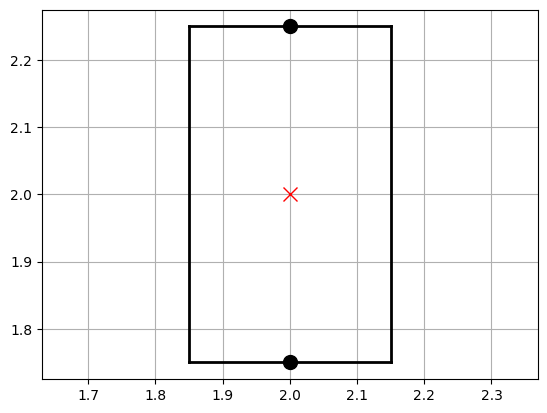

In [34]:
draw_wheelchair(2,2,(pi/2))

🧩 Represent the wheelchair when $(x, y, \theta) = (0, 0, 0), (2, 2, \pi/2), (0, 4, \pi), (-2, 2, 3\pi/2)$.

🗝️ **Hint.** Use the following `draw_arena` function beforehand.

In [35]:
def draw_arena(xmin, xmax, ymin, ymax):
    wh_ratio = (xmax - xmin) / (ymax - ymin)
    figsize = fig_width, fig_height = 16, 16 / wh_ratio
    figure(figsize=figsize)
    axes = gca()
    axes.axis([xmin, xmax, ymin, ymax])
    axes.set_aspect(1)
    xticks(arange(xmin, xmax+1, 1))
    yticks(arange(ymin, ymax+1, 1))
    grid(True)

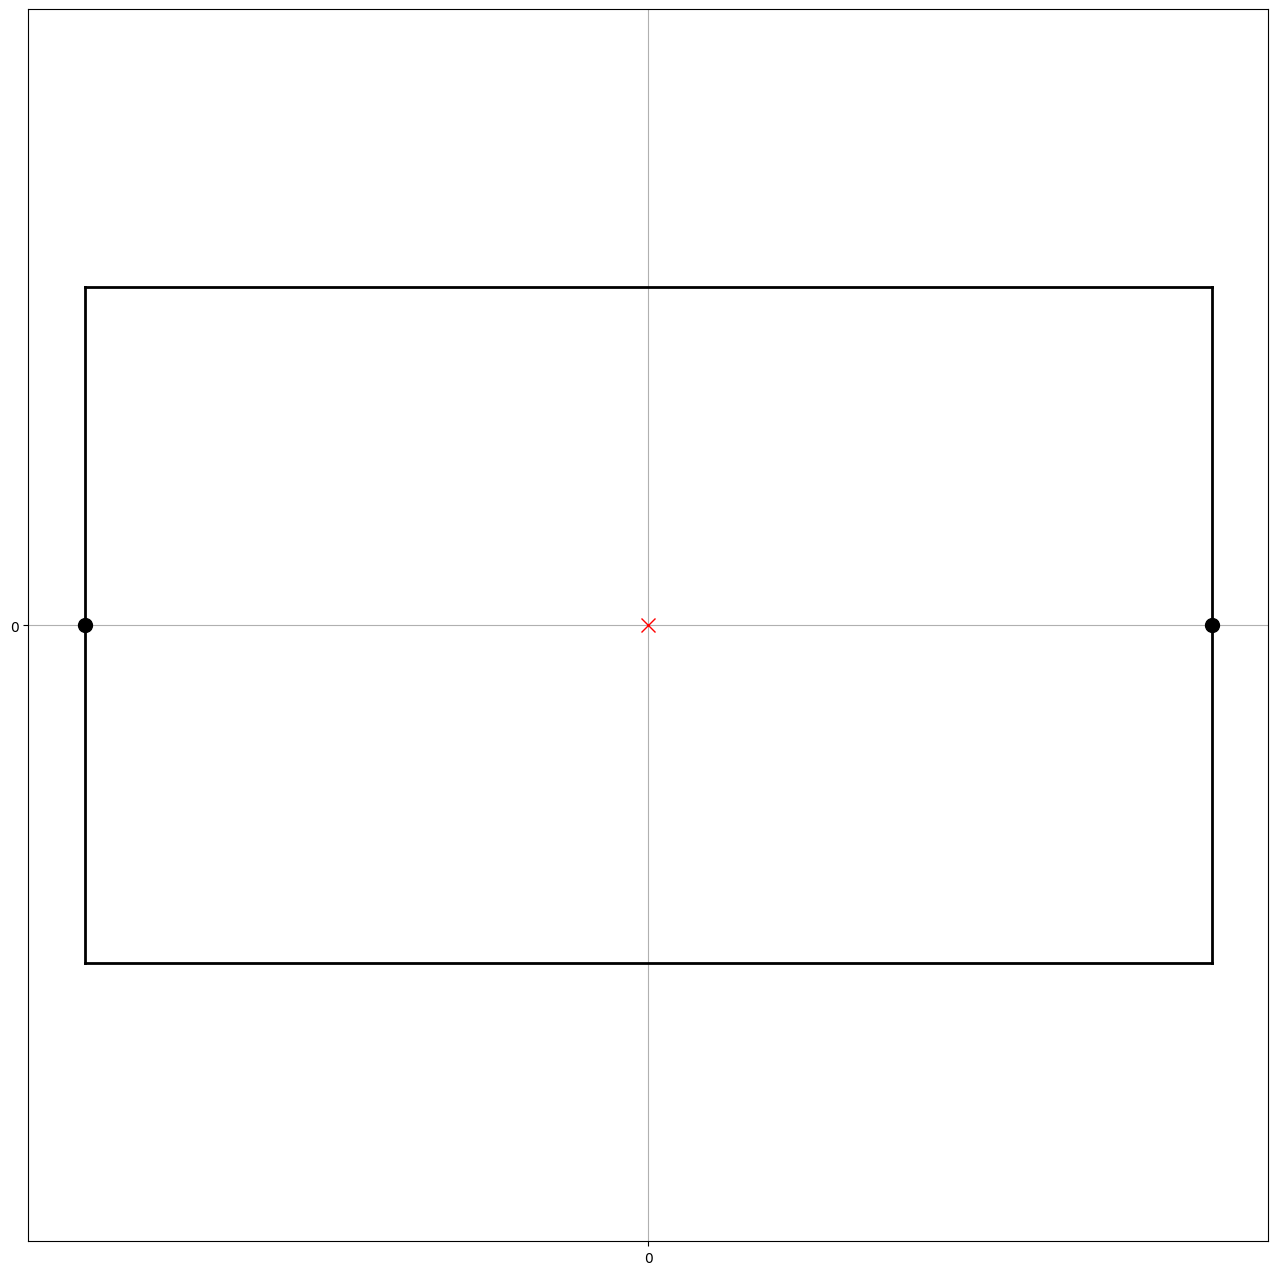

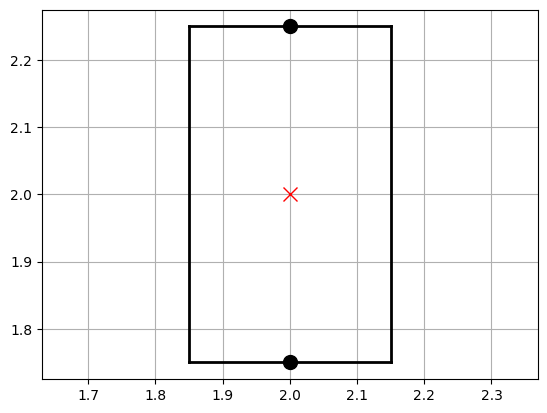

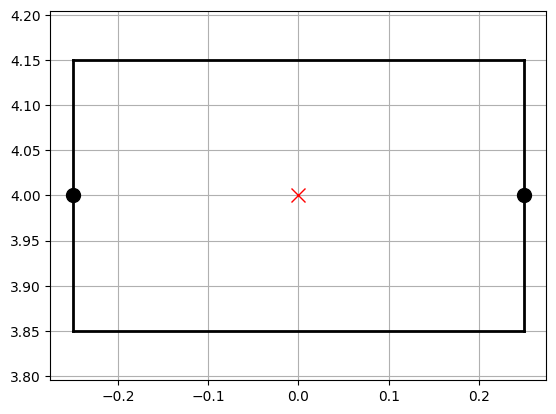

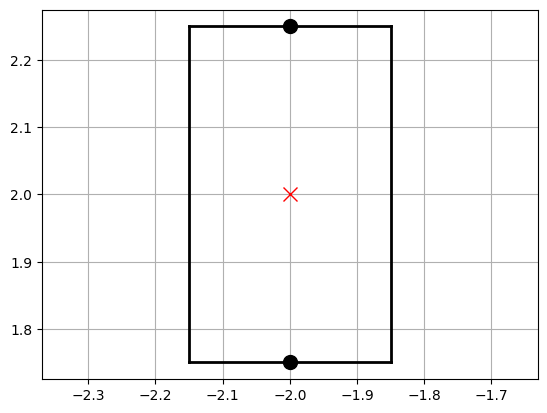

In [36]:
xmin, xmax = -5, 5
ymin, ymax = -5, 5
draw_arena(xmin, xmax, ymin, ymax)
draw_wheelchair(0, 0, 0)
draw_wheelchair(2, 2, np.pi/2)
draw_wheelchair(0, 4, np.pi)
draw_wheelchair(-2, 2, 3*np.pi/2)


### Kinematic Modeling

We assume that we can control the wheels angular velocities $\omega_l = \dot{\phi}_l$ and $\omega_r = \dot{\phi}_r$ (this is a *kinematic* model of the wheelchair).
We also assume that the wheelchair fixed wheels roll without slipping. 

🧩 Establish the differential equations that relate $\dot{x}$,
$\dot{y}$ and $\dot{\theta}$ with $\omega_l$ and $\omega_r$.

**Answer:**

$\dot{x} = \frac{R_w}{2} (\omega_l + \omega_r) \cos(\theta)$

$\dot{y} = \frac{R_w}{2} (\omega_l + \omega_r) \sin(\theta)$

$\dot{\theta} = \frac{R_w}{L} (\omega_r - \omega_l)$

where 𝐿 is the distance between the centers of the two wheels.

### Analysis

🧩 Show that if $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$ (which includes the case of constant inputs), this system is well-posed.

**Answer:**

To show that the system is well-posed, we need to verify that it satisfies the Lipschitz condition with respect to both the state and input variables.

Let $\mathbf{x} = [x, y, \theta]^T$ and $\mathbf{u} = [\omega_l, \omega_r]^T$ be the state and input vectors, respectively. The system can be expressed in the following compact form:

$\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \mathbf{u}) = \begin{bmatrix} \dot{x} \ \dot{y} \ \dot{\theta} \end{bmatrix} = \begin{bmatrix} \frac{R_w}{2} (\omega_l + \omega_r) \cos(\theta) \ \frac{R_w}{2} (\omega_l + \omega_r) \sin(\theta) \ \frac{R_w}{L} (\omega_r - \omega_l) \end{bmatrix}$

The Jacobian matrix of the system is:

$\mathbf{J}(\mathbf{x}, \mathbf{u}) = \begin{bmatrix} 0 & 0 & -\frac{R_w}{2} (\omega_l + \omega_r) \sin(\theta) \ 0 & 0 & \frac{R_w}{2} (\omega_l + \omega_r) \cos(\theta) \ 0 & 0 & -\frac{R_w}{L} \end{bmatrix}$

The norm of the Jacobian matrix is:

$||\mathbf{J}(\mathbf{x}, \mathbf{u})|| = \frac{R_w}{L}$

Since $\omega_l$ and $\omega_r$ are continuously differentiable functions of $(x, y, \theta)$, it follows that $||\mathbf{J}(\mathbf{x}, \mathbf{u})||$ is a continuous function of $(x, y, \theta)$ and $(\omega_l, \omega_r)$. Therefore, there exists a constant $K$ such that

$||\mathbf{f}(\mathbf{x}_1, \mathbf{u}_1) - \mathbf{f}(\mathbf{x}_2, \mathbf{u}_2)|| \leq K ||\mathbf{x}_1 - \mathbf{x}_2|| + K ||\mathbf{u}_1 - \mathbf{u}_2||$

which shows that the system is Lipschitz continuous with respect to the initial conditions and inputs, and hence the system is well-posed by the Picard-Lindelöf theorem.

🧩 Show that if $\omega_l$ and $\omega_r$ are constants, the maximal solution associated to any initial state is global. Is is still true of $\omega_l$ and $\omega_r$ are arbitrary continuously differentiable functions of $(x, y, \theta)$ ?

**Answer:**

If the wheel angular velocities $\omega_l$ and $\omega_r$ are constant, then the system is time-invariant. This means that the maximal solution associated with any initial state is global. This is because the system satisfies the conditions of the Picard-Lindelöf theorem, which guarantees the existence and uniqueness of solutions for any initial state.

However, if the wheel angular velocities are not constant and are instead arbitrary continuously differentiable functions of $(x,y,\theta)$, then the system is time-varying. In this case, the maximal solution associated with a particular initial state may not be global. This is because the system may not satisfy the conditions of the Picard-Lindelöf theorem. The solution may become unstable or divergent in some regions of the state space.

To determine the stability properties of the system and the existence of global solutions, additional analysis is required. This may involve numerical simulations or analytical methods such as Lyapunov stability analysis.

### Vector Field

In the sequel, `omega` is a function that computes the input vector $\omega := (\omega_l, \omega_r)$ given the time $t$ and $(x, y, \theta)$ (thus, it may depend on the time and/or on the system state if needed). For example:

🧩 Implement a function `fun(t, xytheta)` that computes $(\dot{x}, \dot{y}, \dot{\theta})$ given the time $t$ and $(x,y,\theta)$ (and implicitly the inputs $\omega$ computed by the function `omega`).

In [ ]:
def fun(t, xytheta):
    x, y, theta = xytheta
    omega_l, omega_r = omega(t, xytheta)
    x_dot = (Rw / 2) * (omega_l + omega_r) * np.cos(theta)
    y_dot = (Rw / 2) * (omega_l + omega_r) * np.sin(theta)
    theta_dot = (Rw / L) * (omega_r - omega_l)
    return np.array([x_dot, y_dot, theta_dot])

### Simulation Setup

🧩 Simulate the wheelchair dynamics for 4 seconds when $(x_0, y_0, \theta_0)(t=0) = (0.0, 0.0, 0.0)$,
and the wheels velocities are the constants $\omega_l = (1 - L/4)  \pi / R \mbox{ rad/s}$ and $\omega_r = (1 + L/4)  \pi / R_w \mbox{ rad/s}$.
(Compute the dense outputs.)
   

In [ ]:
# Define initial state
x0, y0, theta0 = 0.0, 0.0, 0.0
xytheta0 = np.array([x0, y0, theta0])

# Define time interval
t_span = (0, 4)

# Integrate ODEs
solution = solve_ivp(fun, t_span, xytheta0, dense_output=True)

# Extract dense output function
trajectory = solution.sol

# Evaluate dense output at some times
t_eval = np.linspace(0, 4, num=100)
states = trajectory(t_eval)

🧩 Use the simulation results to draw the graphs of $x(t)$, $y(t)$ and $\theta(t)$.

In [ ]:
# Plot the simulation results
t_eval = solution.t
x_eval = solution.y[0, :]
y_eval = solution.y[1, :]
theta_eval = solution.y[2, :]

plt.figure(figsize=(10, 8))
plt.plot(t_eval, x_eval, label='x(t)')
plt.plot(t_eval, y_eval, label='y(t)')
plt.plot(t_eval, theta_eval, label='theta(t)')
plt.legend()
plt.grid(True)
plt.xlabel('Time (s)')
plt.ylabel('Position/angle (m/rad)')
plt.title('Wheelchair Kinematic Simulation Results')
plt.show()

🧩 Use the simulation results to display the robot location every 0.5 second.

🧩 What should be the analytical expression of $x(t)$, $y(t)$ and $\theta(t)$? 

**Answer:**

🧩 Do you experimental results match the theoretical results ? Draw the curves of the simulation error at time $t$ for $x$, $y$ and $\theta$.

🧩 If needed, adjust the simulation parameters until this error is uniformly less than $2 \times 10^{-5}$ for every component of $(x, y, \theta)$.